In [11]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [12]:
os.environ['GOOGLE_API_KEY']=os.getenv("GOOGLE_API_KEY")

In [14]:
# config the  model
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')
output=model.invoke("explain nlp")
print(output.content)

Natural Language Processing (NLP) is a branch of artificial intelligence (AI) that focuses on enabling computers to understand, interpret, and generate human language.  In simpler terms, it's about teaching computers to "read" and "write" in a way that's meaningful and useful.

Here's a breakdown of key aspects:

**What NLP does:**

* **Understanding Language:** This involves tasks like:
    * **Tokenization:** Breaking down text into individual words or units (tokens).
    * **Part-of-Speech (POS) Tagging:** Identifying the grammatical role of each word (noun, verb, adjective, etc.).
    * **Named Entity Recognition (NER):** Identifying and classifying named entities like people, organizations, locations, etc.
    * **Sentiment Analysis:** Determining the emotional tone of a text (positive, negative, neutral).
    * **Word Sense Disambiguation:** Determining the correct meaning of a word based on its context.
    * **Parsing:** Analyzing the grammatical structure of a sentence.

* **G

Config the embeddings model

In [16]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
len(embeddings.embed_query("Today is a good day"))

384

Lets take a data set, embedd it and store in the db

In [17]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [19]:
loader=DirectoryLoader("../data",glob="*.txt",loader_cls=TextLoader)
docs=loader.load()
docs[0].page_content

"🇺🇸 Overview of the U.S. Economy\nThe United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.\n\nU.S. GDP – Size, Composition, and Global Share\nAs of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ranks 2nd). The U.S. GDP per capita is also among the highest, hover

In [20]:
text_splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=20)
new_docs=text_splitter.split_documents(docs)
new_docs

[Document(metadata={'source': '..\\data\\usa.txt'}, page_content='🇺🇸 Overview of the U.S. Economy'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='U.S. GDP – Size, Composition, and Global Sha

In [21]:
doc_string = [doc.page_content for doc in new_docs]
doc_string

['🇺🇸 Overview of the U.S. Economy',
 'The United States of America possesses the largest economy in the world in terms of nominal GDP, making it the most powerful economic force globally. It operates under a capitalist mixed economy, where the private sector dominates, but the government plays a significant regulatory and fiscal role. With a population of over 335 million people and a high level of technological advancement, the U.S. economy thrives on a foundation of consumer spending, innovation, global trade, and financial',
 'and financial services. It has a highly diversified structure with strong sectors in technology, healthcare, finance, real estate, defense, and agriculture.',
 'U.S. GDP – Size, Composition, and Global Share',
 'As of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ranks 2nd). The U.S. GDP per capita is als

In [22]:
len(doc_string)

29

In [26]:
db=Chroma.from_documents(new_docs,embeddings)
retriever=db.as_retriever(search_kwargs={"k":5})

In [27]:
retriever.invoke("Gdp of the usa")

[Document(metadata={'source': '..\\data\\usa.txt'}, page_content='U.S. GDP – Size, Composition, and Global Share'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='As of 2024, the United States’ nominal GDP is estimated to be around $28 trillion USD, accounting for approximately 25% of the global economy. It ranks #1 in the world by nominal GDP, far ahead of China (which ranks 2nd). The U.S. GDP per capita is also among the highest, hovering around $83,000, which indicates a high standard of living and productivity. In terms of Purchasing Power Parity (PPP), the U.S. ranks second, but nominal GDP is considered more reflective of actual economic size and'),
 Document(metadata={'source': '..\\data\\usa.txt'}, page_content='The U.S. maintains its GDP growth through strong innovation, entrepreneurship, and investment in R&D. With companies like Apple, Google, Amazon, Microsoft, and Tesla leading global markets, the U.S. consistently produces high value across sectors, esp

Creation of the pydantic Class

In [31]:
import operator
from typing import List,TypedDict,Annotated,Sequence
from pydantic import BaseModel,Field
from langchain_core.messages import BaseMessage,HumanMessage,AIMessage
from langchain_core.output_parsers import StrOutputParser,PydanticOutputParser
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import StateGraph,END

In [32]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="The topic selected")
    Reasoning:str=Field(description="The reasoning behind the topic selection")

In [33]:
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "The topic selected", "title": "Topic", "type": "string"}, "Reasoning": {"description": "The reasoning behind the topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'


this below agentstate is just for the explnation like how state works

In [34]:
AgentState={}

In [41]:
AgentState["messages"]=[]

In [42]:
AgentState["messages"].append("Hello")
AgentState["messages"].append("Hi")

In [43]:
AgentState

{'messages': ['Hello', 'Hi']}

In [46]:
AgentState["messages"].append("i hope everything fine")

In [47]:
AgentState

{'messages': ['Hello', 'Hi', 'i hope everything fine']}

In [48]:
AgentState['messages'][-1]

'i hope everything fine'

In [49]:
AgentState['messages'][0]

'Hello'

this agentstate class you need to inside the stategraph

In [50]:
class AgentState(TypedDict):
    messages:Annotated[Sequence[BaseMessage],operator.add]

In [51]:
state={
    "messages":[
    "hi"
]}

In [52]:
state="hiiiiii"

In [53]:
state

'hiiiiii'

In [54]:
def function1(state:AgentState):
    question=state['messages'][-1]
    print("Question:",question)

    template="""
Your task is to classify the given user query into one of the following categories: [USA,Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
"""

    prompt=PromptTemplate(
        template=template,
        input_variables=["question"],
        partial_variables={"format_instructions":parser.get_format_instructions()}
    )

    chain= prompt | model | parser
    response=chain.invoke({"question":question})
    print("Parseed Response:",response)

    return {"messages":[response.Topic]}

In [55]:
state={'messages':["today;s weather"]}

In [56]:
function1(state)

Question: today;s weather
Parseed Response: Topic='Not Related' Reasoning="The query is a general weather request and doesn't specify a location, making it unrelated to the USA."


{'messages': ['Not Related']}

In [57]:
state={"messages":["gdp of superpower"]}

In [58]:
function1(state)

Question: gdp of superpower
Parseed Response: Topic='USA' Reasoning='The query mentions "superpower", which could refer to the USA.  GDP is a common economic indicator, and the USA\'s GDP is frequently discussed.'


{'messages': ['USA']}

In [59]:
def router(state:AgentState):
    print("-> Router ->")

    last_message=state['messages'][-1]
    print("Last Message:",last_message)

    if "usa" in last_message.lower():
        return "RAG CALL"
    else:
        return "LLM CALL"

In [60]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [61]:
#RAG Function
def function2(state:AgentState):
    print("-> RAG CALL ->")

    question = state["messages"][0]\
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )

    rag_chain=(
        {"context":retriever | format_docs , "question":RunnablePassthrough()} 
        | prompt 
        | model 
        | StrOutputParser()
    )

    result=rag_chain.invoke(question)

    return {"messages":[result]}

In [62]:
## LLM Function
def function3(state:AgentState):
    print("-> LLM CALL ->")

    question=state["messages"][0]

    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}


In [66]:
from langgraph.graph import StateGraph,END
workflow=StateGraph(AgentState)

In [67]:
workflow.add_node("Supervisor",function1)
workflow.add_node("RAG",function2)
workflow.add_node("LLM",function3)


In [68]:
workflow.set_entry_point("Supervisor")

In [69]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG CALL":"RAG",
        "LLM CALL":"LLM"
    }
)

In [71]:
workflow.add_edge("RAG",END)
workflow.add_edge("LLM",END)

In [73]:
app=workflow.compile()

Flow chart

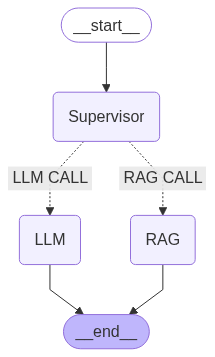

In [89]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [75]:
state={'messages':["today;s weather"]}

In [76]:
app.invoke(state)

Question: today;s weather
Parseed Response: Topic='Not Related' Reasoning="The query is a general weather request and doesn't specify a location, therefore it's not related to the USA."
-> Router ->
Last Message: Not Related
-> LLM CALL ->


{'messages': ['today;s weather',
  'Not Related',
  "I do not have access to real-time information, including current weather.  To get today's weather, please check a reliable weather source such as:\n\n* **A weather app on your smartphone:** Most smartphones come with a pre-installed weather app, or you can download one from your app store.\n* **A weather website:** Many websites provide detailed weather forecasts, such as AccuWeather, The Weather Channel, or your national meteorological service's website.\n* **A smart home device:** If you have a smart speaker (like Alexa or Google Home), you can ask it for the weather.\n* **Local news:** Television and radio news broadcasts often include weather reports."]}

In [83]:
state={'messages':["GDP of usa"]}

In [84]:
app.invoke(state)

Question: GDP of usa
Parseed Response: Topic='USA' Reasoning='The query explicitly asks for the GDP of the USA.'
-> Router ->
Last Message: USA
-> RAG CALL ->


{'messages': ['GDP of usa',
  'USA',
  "The nominal GDP of the USA is approximately $28 trillion USD as of 2024.  This makes it the world's largest economy, accounting for roughly 25% of global GDP.  The US GDP per capita is also very high, around $83,000."]}

In [86]:
state={"messages":["can you tell me the industrial growth of world's most powerful economy?"]}
app.invoke(state)

Question: can you tell me the industrial growth of world's most powerful economy?
Parseed Response: Topic='USA' Reasoning="The query asks about the industrial growth of the world's most powerful economy, which is generally considered to be the USA."
-> Router ->
Last Message: USA
-> RAG CALL ->


{'messages': ["can you tell me the industrial growth of world's most powerful economy?",
  'USA',
  "The provided text states the U.S. has the world's largest economy by nominal GDP.  However, it doesn't offer specific data on industrial growth rates.  Therefore, I cannot answer your question about the industrial growth of the world's most powerful economy."]}

In [87]:

state={"messages":["can you tell me the industrial growth of world's poor economy?"]}
app.invoke(state)

Question: can you tell me the industrial growth of world's poor economy?
Parseed Response: Topic='Not Related' Reasoning="The query asks about the industrial growth of the world's poor economies, which is a global issue not specific to the USA."
-> Router ->
Last Message: Not Related
-> LLM CALL ->


{'messages': ["can you tell me the industrial growth of world's poor economy?",
  'Not Related',
  'There\'s no single, easily quantifiable answer to "the industrial growth of the world\'s poor economies."  The term "poor economies" itself is subjective and depends on the metric used (e.g., GDP per capita, poverty rate, Human Development Index).  Furthermore, industrial growth varies wildly across different countries and regions classified as "poor."\n\nHowever, we can make some general observations:\n\n* **Uneven Growth:** Industrial growth in poorer economies is highly uneven. Some countries have experienced significant industrialization and economic takeoff (e.g., some Southeast Asian nations), while others remain largely agrarian with limited industrial development.  This disparity is influenced by factors like access to resources, infrastructure, education, political stability, and global economic conditions.\n\n* **Shifting Manufacturing:**  A significant portion of manufacturing

In [88]:
result=app.invoke(state)
result['messages'][-1]

Question: can you tell me the industrial growth of world's poor economy?
Parseed Response: Topic='Not Related' Reasoning="The query asks about the industrial growth of the world's poor economies, which is a global issue not specific to the USA."
-> Router ->
Last Message: Not Related
-> LLM CALL ->


'The industrial growth of the world\'s poorest economies is a complex and multifaceted issue, lacking a single, easily quantifiable answer.  There\'s no universally agreed-upon definition of "poor economy," and data collection in these regions is often unreliable or incomplete. However, we can make some general observations:\n\n* **Uneven Growth:** Industrial growth is highly uneven across the poorest economies. Some countries are experiencing significant growth in specific sectors (e.g., garment manufacturing in Bangladesh, resource extraction in some African nations), while others remain largely agrarian with minimal industrial development.  This unevenness is heavily influenced by factors like access to infrastructure, investment, political stability, and global market conditions.\n\n* **Limited Industrial Diversification:** Many poor economies rely heavily on a few primary industries, often extractive (mining, agriculture) or low-value-added manufacturing (garment production). This